### I. Prepare data for Machine Learning model

**Configuration.** The first step is to load packages.

In [1]:
#--- Set KERAS backend to Theano
import os
os.environ['KERAS_BACKEND']='theano'

#--- Load Keras packages
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD

#--- Load Python libraries
import numpy as np
import pandas as pd

Using Theano backend.


**Load data**. We use Pandas to load .dat files for Nodes 150-153 from the Git repository into DataFrame.

In [2]:
#--- Node 150
node150 = pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n150.dat',
                     header=1)
#--- Node 151
node151 = pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n151.dat',
                     header=1)
#--- Node 152
node152 = pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n152.dat',
                     header=1)
#--- Node 153
node153 = pd.read_csv('https://raw.githubusercontent.com/Amitangshu/Irradiance_sensing/master/All_Data_For_EPIC_Roof/MDA300n153.dat',
                      header=1, skiprows=[47728])

Original dataset

In [3]:
node150.head()

,TMSTAMP,RECNBR,PARENT,IRRADIANCE,SOLAROCV,VBATT,TEMP
0,2012-09-14 18:53:15,1,0,40.83,0.95,3.06,85.44
1,2012-09-14 18:55:12,2,0,40.83,0.96,3.05,85.35
2,2012-09-14 19:04:01,3,0,17.50,0.89,3.05,83.80
3,2012-09-14 19:04:59,4,0,17.50,0.88,3.06,83.57
4,2012-09-14 19:05:57,5,0,14.58,0.89,3.06,83.34


**Split Data and Time.** We want the features that can best predict and/or classify irradiance. Thus we choose the 3 most relevant: solar OC voltage, temperature, and time of the day. The following code extracts time from date-time. 

In [4]:
#--- Split TimeStamp into Date and Time columns

node150[['DATE','TIME']] = node150.TMSTAMP.str.split(expand=True)
node151[['DATE','TIME']] = node151.TMSTAMP.str.split(expand=True)
node152[['DATE','TIME']] = node152.TMSTAMP.str.split(expand=True)
node153[['DATE','TIME']] = node153.TMSTAMP.str.split(expand=True)

In [5]:
node150.head()

,TMSTAMP,RECNBR,PARENT,IRRADIANCE,SOLAROCV,VBATT,TEMP,DATE,TIME
0,2012-09-14 18:53:15,1,0,40.83,0.95,3.06,85.44,2012-09-14,18:53:15
1,2012-09-14 18:55:12,2,0,40.83,0.96,3.05,85.35,2012-09-14,18:55:12
2,2012-09-14 19:04:01,3,0,17.50,0.89,3.05,83.80,2012-09-14,19:04:01
3,2012-09-14 19:04:59,4,0,17.50,0.88,3.06,83.57,2012-09-14,19:04:59
4,2012-09-14 19:05:57,5,0,14.58,0.89,3.06,83.34,2012-09-14,19:05:57


**Determine the classes.** This model is trained to classify irradiance into 4 numerical classes. For nodes 150-153, 4 classes are the most recorded values for each node.

In [6]:
#--- Explore data to see the distribution of irradiance values across 4 nodes
count0 = node150.IRRADIANCE.value_counts()
count1 = node151.IRRADIANCE.value_counts()
count2 = node152.IRRADIANCE.value_counts()
count3 = node153.IRRADIANCE.value_counts()

In [7]:
#--- Select 4 class values
class_values = [2.92, 8.75, 3.07, 2.81]

In [8]:
#--- Extract the subsets that contain the 4 class values
subset150 = node150[node150.IRRADIANCE.isin(class_values)]
subset151 = node151[node151.IRRADIANCE.isin(class_values)]
subset152 = node152[node152.IRRADIANCE.isin(class_values)]
subset153 = node153[node153.IRRADIANCE.isin(class_values)]

In [9]:
#--- Merge all the subsets
A_merge = pd.merge(subset150, subset151, how='outer')
B_merge = pd.merge(subset152, subset153, how='outer')
data = pd.merge(A_merge, B_merge, how='outer')

In [10]:
data.head()

,TMSTAMP,RECNBR,PARENT,IRRADIANCE,SOLAROCV,VBATT,TEMP,DATE,TIME
0,2012-09-14 19:17:40,16,0,8.75,0.93,3.06,80.75,2012-09-14,19:17:40
1,2012-09-14 19:18:38,17,0,8.75,0.93,3.06,80.59,2012-09-14,19:18:38
2,2012-09-14 19:19:38,18,0,8.75,0.87,3.06,80.43,2012-09-14,19:19:38
3,2012-09-14 19:20:37,19,0,8.75,0.88,3.06,80.22,2012-09-14,19:20:37
4,2012-09-14 19:21:34,20,0,8.75,0.93,3.06,80.04,2012-09-14,19:21:34


In [11]:
#--- Transform Time column into numeric Time delta (hours)
data.TIME = pd.to_timedelta(data.TIME)
data.TIME = data.TIME.dt.seconds/3600

**Create labels.** The target variable is converted into categories, as required by CNN. 

In [12]:
#--- Convert the labels into categorical classification
#--- Class values: {2.92, 8.75, 3.07, 2.81} correspond to {0, 1, 2, 3}

data.loc[data.IRRADIANCE==2.92, 'IRRADIANCE'] = 0
data.loc[data.IRRADIANCE==8.75, 'IRRADIANCE'] = 1
data.loc[data.IRRADIANCE==3.07, 'IRRADIANCE'] = 2
data.loc[data.IRRADIANCE==2.81, 'IRRADIANCE'] = 3

In [13]:
data.head()

,TMSTAMP,RECNBR,PARENT,IRRADIANCE,SOLAROCV,VBATT,TEMP,DATE,TIME
0,2012-09-14 19:17:40,16,0,1.0,0.93,3.06,80.75,2012-09-14,19.294444
1,2012-09-14 19:18:38,17,0,1.0,0.93,3.06,80.59,2012-09-14,19.310556
2,2012-09-14 19:19:38,18,0,1.0,0.87,3.06,80.43,2012-09-14,19.327222
3,2012-09-14 19:20:37,19,0,1.0,0.88,3.06,80.22,2012-09-14,19.343611
4,2012-09-14 19:21:34,20,0,1.0,0.93,3.06,80.04,2012-09-14,19.359444


**Split data into training and testing.**

We use scikit-learn to separate data to training set (40%) and testing set (30%). The inputs to our CNN model are 4 datasets: X_train, Y_train, X_test, Y_test.

In [14]:
#--- Split data into three parts: training(40%), testing(30%), validation(30%)
#--- Use scikit-learn

import sklearn
from sklearn.model_selection import train_test_split

Train_Set, Test_Set = train_test_split(data, train_size=0.4, test_size=0.3, shuffle=True)

In [15]:
# Extract the feature columns: SOLAROCV, TEMP, TIME

X_train = np.array(Train_Set[['SOLAROCV','TEMP','TIME']]).astype('float64')
X_test = np.array(Test_Set[['SOLAROCV','TEMP','TIME']]).astype('float64')

# Input Shape
shape_ord = (X_train[0].shape)

In [16]:
# Extract the label column: IRRADIANCE

# Cast the label as integer
Y_train = np.array(Train_Set[['IRRADIANCE']]).astype('int')
Y_test = np.array(Test_Set[['IRRADIANCE']]).astype('int')

from keras.utils import to_categorical
# Convert the labels into categorical form
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

In [17]:
print('X_train {SOLAROCV, TEMP, TIME}: Shape =',format(X_train.shape),'\n',X_train)
print('\nY_train {IRRADIANCE}: Shape =',format(Y_train.shape),'\n',Y_train)

X_train {SOLAROCV, TEMP, TIME}: Shape = (47917, 3) 
 [[ 0.85       31.41        0.16888889]
 [ 1.02       53.97       22.66277778]
 [ 0.56       24.66        6.70944444]
 ...
 [ 0.96       32.82        3.80916667]
 [ 0.98       71.51        5.52666667]
 [ 0.68       44.84       23.85472222]]

Y_train {IRRADIANCE}: Shape = (47917, 4) 
 [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


### II. Train the first Convolutional Neural Networks model (CNN)

**1.** Initialize the parameters

In [18]:
# Initialize the parameters
# Number of epochs
nb_epochs = 10
# Batch size
batch_size = 128
# Vanilla SGD
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

**2.** Compile the model

In [ ]:
model = Sequential()

model.add(Dense(64, activation='relu', input_dim=3))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

**3.** Fit the model

In [98]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 4,676
Trainable params: 4,676
Non-trainable params: 0
_________________________________________________________________


In [99]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epochs, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 47917 samples, validate on 35938 samples
Epoch 1/10
47917/47917 [==============================] - 1s 20us/step - loss: 7.6099 - accuracy: 0.5271 - val_loss: 7.1011 - val_accuracy: 0.5594
Epoch 2/10
47917/47917 [==============================] - 1s 17us/step - loss: 7.5073 - accuracy: 0.5338 - val_loss: 7.1011 - val_accuracy: 0.5594
Epoch 3/10
47917/47917 [==============================] - 1s 22us/step - loss: 7.1536 - accuracy: 0.5553 - val_loss: 7.1011 - val_accuracy: 0.5594
Epoch 4/10
47917/47917 [==============================] - 1s 20us/step - loss: 7.1371 - accuracy: 0.5567 - val_loss: 7.1011 - val_accuracy: 0.5594
Epoch 5/10
47917/47917 [==============================] - 1s 20us/step - loss: 7.1094 - accuracy: 0.5584 - val_loss: 7.1011 - val_accuracy: 0.5594
Epoch 6/10
47917/47917 [==============================] - 1s 21us/step - loss: 7.1162 - accuracy: 0.5577 - val_loss: 7.1011 - val_accuracy: 0.5594
Epoch 7/10
47917/47917 [==============================] - 1s 23us/st

**4.** Visualize the results

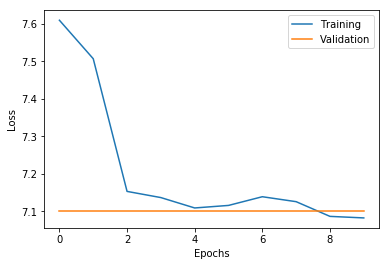

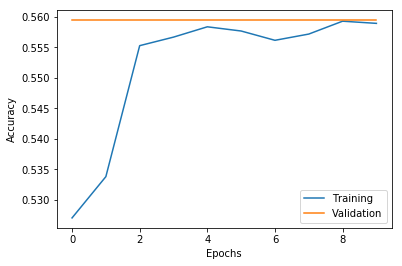

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')

**5.** Evaluate the accuracy of the model

In [101]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 7.101057627502404
Test Accuracy: 0.5594356656074524
